In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import numpy as np

# Chemins des fichiers
long_format_path = '/content/drive/MyDrive/Projet_time_series/Data_long'
output_path = '/content/drive/MyDrive/Projet_time_series/Data_processed'
os.makedirs(output_path, exist_ok=True)

# Fréquences des capteurs
sampling_rates = {
    'PS1': 100, 'PS2': 100, 'PS3': 100, 'PS5': 100, 'PS6': 100,
    'EPS1': 100,
    'FS1': 10, 'FS2': 10,
    'TS1': 1, 'TS2': 1, 'TS3': 1, 'TS4': 1,
    'VS1': 1,
    'CE': 1, 'CP': 1, 'SE': 1
}

# Fonction pour redimensionner les données à 1 Hz
def resample_to_1hz(df, sensor, freq):
    """
    Redimensionne les données d'un capteur à 1 Hz en calculant la moyenne par seconde.
    Args:
        df: DataFrame en format long (cycle_id, Temps (s), Capteur, Point, Valeur)
        sensor: Nom du capteur
        freq: Fréquence d'échantillonnage d'origine (en Hz)
    Returns:
        DataFrame redimensionné à 1 Hz
    """
    if 'cycle_id' not in df.columns:
        raise KeyError(f"Column 'cycle_id' not found in DataFrame for sensor {sensor}")

    # Arrondir Temps (s) à l'entier inférieur pour éviter les points > 59
    df['Temps (s)'] = np.floor(df['Temps (s)']).astype(int)

    if freq == 1:
        # Filtrer pour garder Temps (s) de 0 à 59
        df = df[df['Temps (s)'].between(0, 59)]
        return df[['cycle_id', 'Temps (s)', 'Valeur']].rename(columns={'Valeur': sensor})

    # Pour capteurs > 1 Hz, calculer la moyenne par seconde et filtrer 0 à 59
    df_resampled = df.groupby(['cycle_id', 'Temps (s)'])['Valeur'].mean().reset_index()
    df_resampled = df_resampled[df_resampled['Temps (s)'].between(0, 59)]
    df_resampled = df_resampled.rename(columns={'Valeur': sensor})

    return df_resampled[['cycle_id', 'Temps (s)', sensor]]

# Redimensionner tous les capteurs
resampled_dfs = []
for sensor, freq in sampling_rates.items():
    file_path = f'{long_format_path}/{sensor}_long.csv'
    if not os.path.exists(file_path):
        print(f"File {file_path} not found, skipping sensor {sensor}")
        continue

    df = pd.read_csv(file_path)
    try:
        df_resampled = resample_to_1hz(df, sensor, freq)
        points_per_cycle = df_resampled.groupby('cycle_id')['Temps (s)'].count()
        if (points_per_cycle != 60).any():
            print(f"Warning: Sensor {sensor} has inconsistent number of points per cycle: {points_per_cycle.value_counts().to_dict()}")
        resampled_dfs.append(df_resampled)
        print(f'{sensor} redimensionné à 1 Hz')
    except KeyError as e:
        print(f"Error processing sensor {sensor}: {e}")
        continue

# Vérifier si des DataFrames ont été générés
if not resampled_dfs:
    raise ValueError("No resampled DataFrames were generated. Check input files and column names.")

# Fusionner les données redimensionnées avec un merge 'inner'
merged_df = resampled_dfs[0]
for df in resampled_dfs[1:]:
    merged_df = pd.merge(merged_df, df, on=['cycle_id', 'Temps (s)'], how='inner')
print("Fusion des données redimensionnées terminée")

# Supprimer les lignes où Temps (s) = 0
initial_rows = len(merged_df)
merged_df = merged_df[merged_df['Temps (s)'] != 0]
print(f"Removed {initial_rows - len(merged_df)} rows where Temps (s) = 0, new shape: {merged_df.shape}")

# Vérifier les cycles et points par cycle
expected_cycles = 2205
unique_cycles = merged_df['cycle_id'].nunique()
if unique_cycles != expected_cycles:
    print(f"Warning: Only {unique_cycles} cycles found, expected {expected_cycles}")
points_per_cycle = merged_df.groupby('cycle_id')['Temps (s)'].count()
if (points_per_cycle != 59).any():
    print(f"Warning: Inconsistent points per cycle after deletion: {points_per_cycle.value_counts().to_dict()}")

# Charger le fichier profile.csv
profile_path = f'{long_format_path}/../Data_csv/profile.csv'
if not os.path.exists(profile_path):
    raise FileNotFoundError(f"Profile file {profile_path} not found")

profile = pd.read_csv(profile_path)

# Ajouter cycle_id à profile si nécessaire
if 'cycle_id' not in profile.columns:
    profile['cycle_id'] = profile.index
    print("Added 'cycle_id' to profile DataFrame based on index")

# Vérifier les colonnes de profile
print("Colonnes de profile.csv:", profile.columns.tolist())

# Ajouter les informations du profil
merged_df = merged_df.merge(profile, on='cycle_id', how='left')

# Vérifier les valeurs manquantes
print("Valeurs manquantes dans merged_df après suppression:")
print(merged_df.isna().sum())

# Vérifier la qualité des données de SE
se_non_zero = merged_df[merged_df['SE'] > 0]['SE'].count()
print(f"Nombre de valeurs non nulles pour SE: {se_non_zero} sur {len(merged_df)} ({se_non_zero/len(merged_df)*100:.2f}%)")

# Afficher les 10 premières lignes
print("First 10 rows of merged_df:")
print(merged_df.head(10))

# Sauvegarder les données fusionnées
merged_df.to_csv(f'{output_path}/merged_resampled_1hz_no_t0.csv', index=False)
print("Données redimensionnées et fusionnées (sans Temps (s)=0) sauvegardées dans merged_resampled_1hz_no_t0.csv")

PS1 redimensionné à 1 Hz
PS2 redimensionné à 1 Hz
PS3 redimensionné à 1 Hz
PS5 redimensionné à 1 Hz
PS6 redimensionné à 1 Hz
EPS1 redimensionné à 1 Hz
FS1 redimensionné à 1 Hz
FS2 redimensionné à 1 Hz
TS1 redimensionné à 1 Hz
TS2 redimensionné à 1 Hz
TS3 redimensionné à 1 Hz
TS4 redimensionné à 1 Hz
VS1 redimensionné à 1 Hz
CE redimensionné à 1 Hz
CP redimensionné à 1 Hz
SE redimensionné à 1 Hz
Fusion des données redimensionnées terminée
Removed 0 rows where Temps (s) = 0, new shape: (130095, 18)
Added 'cycle_id' to profile DataFrame based on index
Colonnes de profile.csv: ['Cooler_condition', 'Valve_condition', 'Internal_pump_leakage', 'Hydraulic_accumulator', 'Stable_flag', 'cycle_id']
Valeurs manquantes dans merged_df après suppression:
cycle_id                 0
Temps (s)                0
PS1                      0
PS2                      0
PS3                      0
PS5                      0
PS6                      0
EPS1                     0
FS1                      0
FS2    

In [ ]:
# Imputer les valeurs manquantes avec forward fill
print("Valeurs manquantes dans merged_df avant imputation:")
print(merged_df.isna().sum())
sensor_columns = [col for col in sampling_rates.keys()]
merged_df[sensor_columns] = merged_df.groupby('cycle_id')[sensor_columns].fillna(method='ffill')
print("Valeurs manquantes dans merged_df après imputation:")
print(merged_df.isna().sum())

Valeurs manquantes dans merged_df avant imputation:
cycle_id                 0
Temps (s)                0
PS1                      0
PS2                      0
PS3                      0
PS5                      0
PS6                      0
EPS1                     0
FS1                      0
FS2                      0
TS1                      0
TS2                      0
TS3                      0
TS4                      0
VS1                      0
CE                       0
CP                       0
SE                       0
Cooler_condition         0
Valve_condition          0
Internal_pump_leakage    0
Hydraulic_accumulator    0
Stable_flag              0
dtype: int64
Valeurs manquantes dans merged_df après imputation:
cycle_id                 0
Temps (s)                0
PS1                      0
PS2                      0
PS3                      0
PS5                      0
PS6                      0
EPS1                     0
FS1                      0
FS2                

In [ ]:
!pip install keras-tcn

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Conv1D, MaxPooling1D, MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from prophet import Prophet
import joblib
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Chemins des fichiers
output_path = '/content/drive/MyDrive/Projet_time_series/Data_processed'
data_file = f'{output_path}/merged_resampled_1hz_no_t0.csv'
model_save_path = '/content/drive/MyDrive/Projet_time_series/Models'

# Créer le dossier Models s'il n'existe pas
os.makedirs(model_save_path, exist_ok=True)

# Charger les données
merged_df = pd.read_csv(data_file)
print("Shape of merged_df:", merged_df.shape)
print("First 5 rows of merged_df:")
print(merged_df.head(5))

Shape of merged_df: (130095, 23)
First 5 rows of merged_df:
   cycle_id  Temps (s)       PS1      PS2  PS3      PS5      PS6      EPS1  \
0         0          1  184.7723  0.19044  0.0  9.95992  9.83701  2920.048   
1         0          2  189.7699  0.02297  0.0  9.96455  9.83842  2858.938   
2         0          3  191.3452  0.00283  0.0  9.96817  9.84580  2946.510   
3         0          4  191.2842  0.00000  0.0  9.97272  9.84868  2946.164   
4         0          5  191.3105  0.00000  0.0  9.97742  9.85498  2945.786   

      FS1      FS2  ...     TS4    VS1      CE     CP      SE  \
0  0.0008  10.1706  ...  30.363  0.604  47.202  2.184  68.039   
1  0.0020  10.1637  ...  30.375  0.605  47.273  2.184   0.000   
2  0.0011  10.1747  ...  30.367  0.611  47.250  2.184   0.000   
3  0.0010  10.1758  ...  30.367  0.603  47.332  2.185   0.000   
4  0.0017  10.1731  ...  30.379  0.608  47.213  2.178   0.000   

   Cooler_condition  Valve_condition  Internal_pump_leakage  \
0                

Nombre de valeurs non nulles pour SE: 112455 sur 130095 (86.44%)


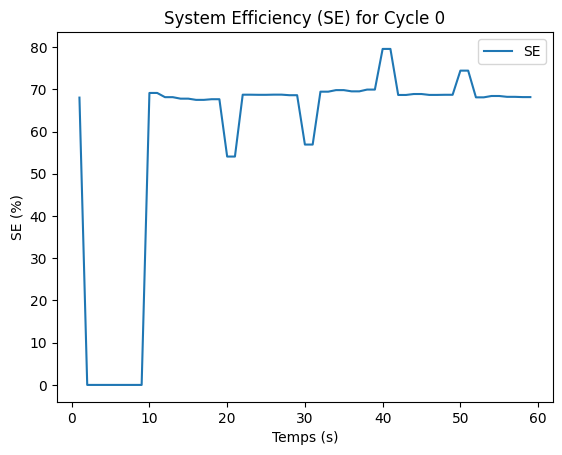

Test ADF pour SE:
Statistique ADF: -16.563977476771456
p-value: 1.8961851729075503e-29
Valeurs critiques: {'1%': np.float64(-3.430400295176217), '5%': np.float64(-2.8615622297364762), '10%': np.float64(-2.5667818321010007)}
Test ADF pour PS1:
Statistique ADF: -21.170498176571837
p-value: 0.0
Valeurs critiques: {'1%': np.float64(-3.430400295176217), '5%': np.float64(-2.8615622297364762), '10%': np.float64(-2.5667818321010007)}
Test ADF pour TS1:
Statistique ADF: -0.5005658656493415
p-value: 0.8919060243744786
Valeurs critiques: {'1%': np.float64(-3.430400295176217), '5%': np.float64(-2.8615622297364762), '10%': np.float64(-2.5667818321010007)}
TS1 est non-stationnaire, appliquant une différenciation...


In [ ]:
# Étape 1: Vérifier la qualité des données de SE
se_non_zero = merged_df[merged_df['SE'] > 0]['SE'].count()
print(f"Nombre de valeurs non nulles pour SE: {se_non_zero} sur {len(merged_df)} ({se_non_zero/len(merged_df)*100:.2f}%)")

# Visualiser SE pour un cycle
sample_cycle = merged_df[merged_df['cycle_id'] == 0]
plt.plot(sample_cycle['Temps (s)'], sample_cycle['SE'], label='SE')
plt.xlabel('Temps (s)')
plt.ylabel('SE (%)')
plt.title('System Efficiency (SE) for Cycle 0')
plt.legend()
plt.show()

# Si SE a trop de zéros, utiliser seulement les valeurs non nulles
if se_non_zero / len(merged_df) < 0.1:
    print("Warning: SE has many zero values, considering non-zero values for modeling.")
    merged_df_non_zero = merged_df[merged_df['SE'] > 0]
else:
    merged_df_non_zero = merged_df

# Étape 2: Vérifier la non-stationnarité
def check_stationarity(series, name):
    result = adfuller(series.dropna())
    print(f"Test ADF pour {name}:")
    print(f'Statistique ADF: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Valeurs critiques: {result[4]}')
    return result[1] < 0.05

for col in ['SE', 'PS1', 'TS1']:
    is_stationary = check_stationarity(merged_df_non_zero[col], col)
    if not is_stationary:
        print(f"{col} est non-stationnaire, appliquant une différenciation...")
        merged_df_non_zero[f'{col}_diff'] = merged_df_non_zero.groupby('cycle_id')[col].diff().fillna(0)

In [ ]:
# Étape 3: Préparer les données pour la modélisation
scaler = MinMaxScaler()
sensor_columns = ['PS1', 'PS2', 'PS3', 'PS5', 'PS6', 'EPS1', 'FS1', 'FS2', 'TS1', 'TS2', 'TS3', 'TS4', 'VS1', 'CE', 'CP', 'SE']
merged_df_non_zero[sensor_columns] = scaler.fit_transform(merged_df_non_zero[sensor_columns])

# Créer des séquences pour la prédiction directe
def create_sequences(data, seq_length, target_col, feature_cols):
    X, y = [], []
    for cycle in data['cycle_id'].unique():
        cycle_data = data[data['cycle_id'] == cycle]
        for i in range(len(cycle_data) - seq_length):
            X.append(cycle_data[feature_cols].iloc[i:i+seq_length].values)
            y.append(cycle_data[target_col].iloc[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10
feature_cols = [col for col in sensor_columns if col != 'SE']
X, y = create_sequences(merged_df_non_zero, seq_length, 'SE', feature_cols)
print(f"Shape of X: {X.shape}, Shape of y: {y.shape}")

# Diviser en ensembles d'entraînement et de test
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


Shape of X: (108045, 10, 15), Shape of y: (108045,)


In [ ]:
# Étape 4: Modèles de prédiction directe
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

def build_gru_model(input_shape):
    model = Sequential([
        GRU(50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        GRU(50),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

def build_ann_model(input_shape):
    model = Sequential([
        Dense(100, activation='relu', input_shape=(input_shape[0] * input_shape[1],)),
        Dropout(0.2),
        Dense(50, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

def build_cnn_lstm_model(input_shape):
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        LSTM(50, return_sequences=True),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

def build_transformer_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    x = MultiHeadAttention(num_heads=4, key_dim=64)(inputs, inputs)
    x = LayerNormalization(epsilon=1e-6)(x + inputs)
    x = Conv1D(filters=64, kernel_size=1, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = GlobalAveragePooling1D()(x)
    outputs = Dense(1)(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

def build_prophet_model(data, feature_cols):
    prophet_data = data[['Temps (s)', 'SE'] + feature_cols].copy()
    prophet_data['ds'] = pd.date_range(start='2020-01-01', periods=len(prophet_data), freq='S')
    prophet_data = prophet_data.rename(columns={'SE': 'y'})
    model = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=True)
    for col in feature_cols:
        model.add_regressor(col)
    return model, prophet_data

# Entraîner et évaluer les modèles neuronaux
input_shape = (seq_length, len(feature_cols))
print(f"Input shape for models: {input_shape}")
models = {
    'LSTM': build_lstm_model(input_shape),
    'GRU': build_gru_model(input_shape),
    'ANN': build_ann_model(input_shape),
    'CNN-LSTM': build_cnn_lstm_model(input_shape),
    'Transformer': build_transformer_model(input_shape)
    # Uncomment below if keras-tcn is installed
    # 'TCN': build_tcn_model(input_shape)
}

# Store predictions and results
predictions = {}
results = {}
for name, model in models.items():
    print(f"Entraînement du modèle {name}...")
    if name == 'ANN':
        X_train_flat = X_train.reshape(X_train.shape[0], -1)
        X_test_flat = X_test.reshape(X_test.shape[0], -1)
        model.fit(X_train_flat, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)
        y_pred = model.predict(X_test_flat)
    else:
        model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)
        y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MSE': mse, 'MAE': mae, 'R²': r2}
    predictions[name] = y_pred.flatten()
    print(f"{name} - MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
    # Save neural model
    model.save(os.path.join(model_save_path, f'direct_{name.lower()}_se_pred_v1.h5'))


Input shape for models: (10, 15)
Entraînement du modèle LSTM...
Epoch 1/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 28s 12ms/step - loss: 0.0160 - val_loss: 0.0016
Epoch 2/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - loss: 0.0021 - val_loss: 0.0050
Epoch 3/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 4/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 42s 10ms/step - loss: 7.3891e-04 - val_loss: 6.7207e-04
Epoch 5/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 39s 10ms/step - loss: 5.1265e-04 - val_loss: 0.0016
Epoch 6/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - loss: 4.3970e-04 - val_loss: 8.9200e-04
Epoch 7/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - loss: 3.6052e-04 - val_loss: 0.0011
Epoch 8/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - loss: 3.1019e-04 - val_loss: 5.0692e-04
Epoch 9/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 40s 10ms/step - loss: 3.0389e-04 - val_loss: 2.3555e-04
Epoch 10/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - loss: 2.8804e-04 - val_loss

LSTM - MSE: 0.0001, MAE: 0.0061, R²: 0.9774
Entraînement du modèle GRU...
Epoch 1/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 30s 13ms/step - loss: 0.0159 - val_loss: 0.0044
Epoch 2/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - loss: 0.0019 - val_loss: 0.0057
Epoch 3/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 40s 12ms/step - loss: 9.4953e-04 - val_loss: 0.0035
Epoch 4/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 43s 12ms/step - loss: 6.3814e-04 - val_loss: 0.0017
Epoch 5/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 40s 12ms/step - loss: 4.9165e-04 - val_loss: 0.0015
Epoch 6/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - loss: 4.6334e-04 - val_loss: 0.0014
Epoch 7/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - loss: 4.1271e-04 - val_loss: 4.3156e-04
Epoch 8/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - loss: 3.7464e-04 - val_loss: 0.0012
Epoch 9/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 42s 12ms/step - loss: 3.5793e-04 - val_loss: 4.4802e-04
Epoch 10/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 27s 13ms/step - loss: 3.4665e-04 - va

GRU - MSE: 0.0001, MAE: 0.0086, R²: 0.9542
Entraînement du modèle ANN...
Epoch 1/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0190 - val_loss: 0.0039
Epoch 2/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0023 - val_loss: 0.0040
Epoch 3/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0018 - val_loss: 8.0803e-04
Epoch 4/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0014 - val_loss: 6.2776e-04
Epoch 5/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0014 - val_loss: 0.0026
Epoch 6/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0013 - val_loss: 0.0037
Epoch 7/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0013 - val_loss: 6.4095e-04
Epoch 8/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0012 - val_loss: 0.0059
Epoch 9/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0012 - val_loss: 0.0063
Epoch 10/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0012 - val_loss: 0.0064
Epoch 11/20
2161/2161 ━━━━━━━━━━

ANN - MSE: 0.0080, MAE: 0.0864, R²: -2.2378
Entraînement du modèle CNN-LSTM...
Epoch 1/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 0.0172 - val_loss: 7.1842e-04
Epoch 2/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 0.0018 - val_loss: 3.6144e-04
Epoch 3/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 7.9332e-04 - val_loss: 7.7417e-04
Epoch 4/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - loss: 4.8509e-04 - val_loss: 2.9874e-04
Epoch 5/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 3.6070e-04 - val_loss: 8.5771e-04
Epoch 6/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 3.2165e-04 - val_loss: 1.0711e-04
Epoch 7/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 2.9897e-04 - val_loss: 7.5649e-05
Epoch 8/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 2.8463e-04 - val_loss: 1.0678e-04
Epoch 9/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 2.7482e-04 - val_loss: 1.7833e-04
Epoch 10/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step 

CNN-LSTM - MSE: 0.0001, MAE: 0.0072, R²: 0.9623
Entraînement du modèle Transformer...
Epoch 1/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - loss: 0.0161 - val_loss: 0.0116
Epoch 2/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 3/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 4/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 5/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0014 - val_loss: 0.0021
Epoch 6/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - loss: 0.0012 - val_loss: 0.0028
Epoch 7/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 0.0010 - val_loss: 0.0022
Epoch 8/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - loss: 9.6441e-04 - val_loss: 0.0025
Epoch 9/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 8.3490e-04 - val_loss: 0.0051
Epoch 10/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - loss: 7.7871e-04 - val_loss: 0.0049
Epoch 11/2

Transformer - MSE: 0.0010, MAE: 0.0239, R²: 0.6092


In [ ]:
# Entraîner Prophet séparément
prophet_model, prophet_data = build_prophet_model(merged_df_non_zero, feature_cols)
prophet_train_size = int(0.8 * len(prophet_data))
prophet_train = prophet_data.iloc[:prophet_train_size]
prophet_test = prophet_data.iloc[prophet_train_size:]
print("Entraînement du modèle Prophet...")
prophet_model.fit(prophet_train)
future = prophet_test[['ds'] + feature_cols]
forecast = prophet_model.predict(future)
y_pred_prophet = forecast['yhat'].values
mse_prophet = mean_squared_error(prophet_test['y'], y_pred_prophet)
mae_prophet = mean_absolute_error(prophet_test['y'], y_pred_prophet)
r2_prophet = r2_score(prophet_test['y'], y_pred_prophet)
results['Prophet'] = {'MSE': mse_prophet, 'MAE': mae_prophet, 'R²': r2_prophet}
predictions['Prophet'] = y_pred_prophet
print(f"Prophet - MSE: {mse_prophet:.4f}, MAE: {mae_prophet:.4f}, R²: {r2_prophet:.4f}")
# Save Prophet model
joblib.dump(prophet_model, os.path.join(model_save_path, 'direct_prophet_se_pred_v1.pkl'))

Entraînement du modèle Prophet...


DEBUG:cmdstanpy:input tempfile: /tmp/tmp8w_jxoj2/08ph1gqt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8w_jxoj2/0wg9v08d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34392', 'data', 'file=/tmp/tmp8w_jxoj2/08ph1gqt.json', 'init=/tmp/tmp8w_jxoj2/0wg9v08d.json', 'output', 'file=/tmp/tmp8w_jxoj2/prophet_modelcnzw5jxx/prophet_model-20250614193730.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:37:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:38:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet - MSE: 0.0099, MAE: 0.0647, R²: 0.8142


['/content/drive/MyDrive/Projet_time_series/Models/direct_prophet_se_pred_v1.pkl']

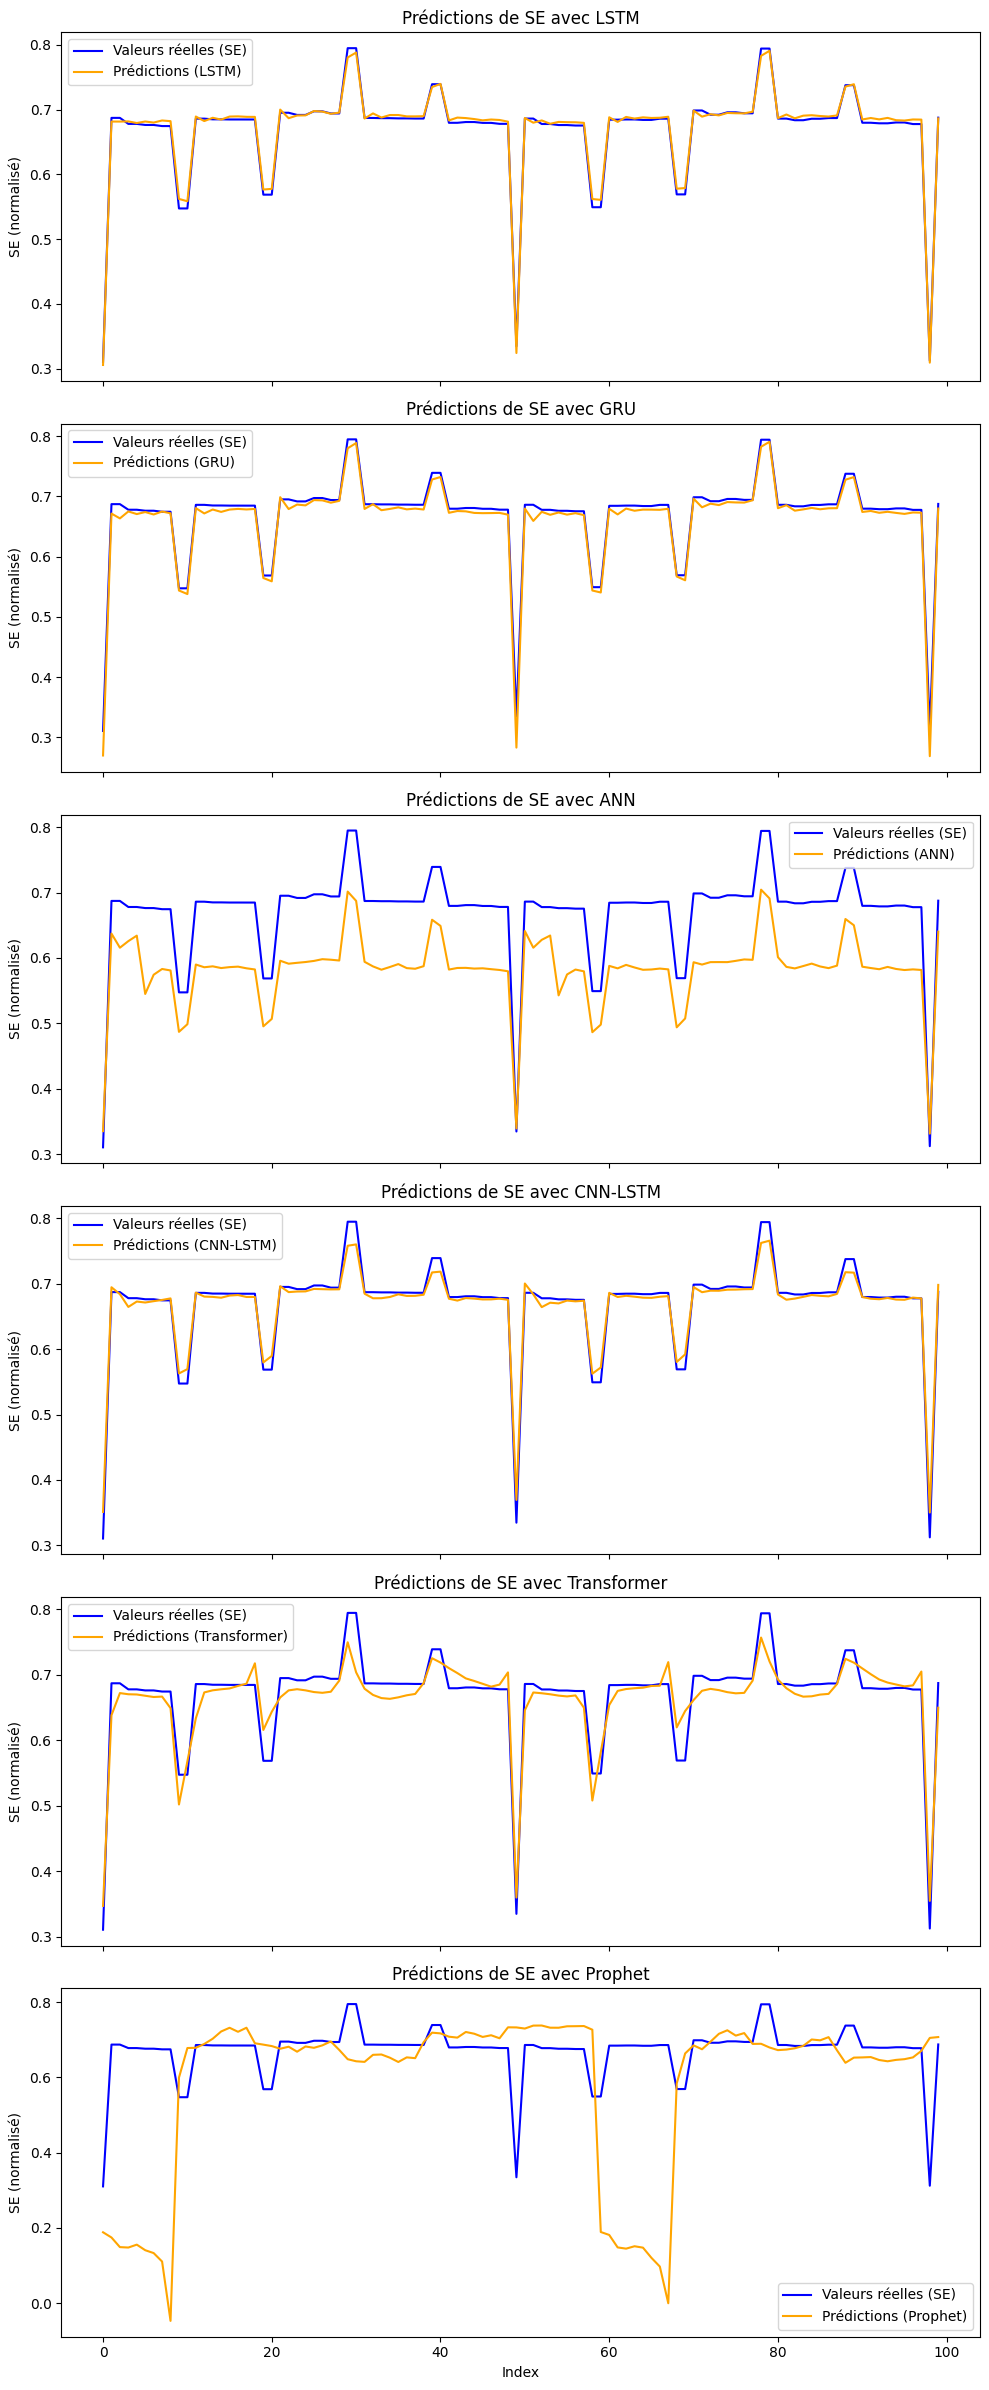

In [ ]:
# Visualiser les prédictions pour tous les modèles
n_models = len(results)
fig, axes = plt.subplots(n_models, 1, figsize=(10, 4 * n_models), sharex=True)
if n_models == 1:
    axes = [axes]
for i, (name, y_pred) in enumerate(predictions.items()):
    axes[i].plot(y_test[:100], label='Valeurs réelles (SE)', color='blue')
    axes[i].plot(y_pred[:100], label=f'Prédictions ({name})', color='orange')
    axes[i].set_ylabel('SE (normalisé)')
    axes[i].set_title(f'Prédictions de SE avec {name}')
    axes[i].legend()
axes[-1].set_xlabel('Index')
plt.tight_layout()
plt.savefig(os.path.join(model_save_path, 'all_models_predictions.png'))
plt.show()


In [ ]:
# Afficher les résultats
print("Résultats des modèles de prédiction directe:")
for name, metrics in results.items():
    print(f"{name}: {metrics}")


Résultats des modèles de prédiction directe:
LSTM: {'MSE': 5.568239257323678e-05, 'MAE': 0.006085558283848438, 'R²': 0.9773985852938081}
GRU: {'MSE': 0.0001128619118575988, 'MAE': 0.008573648010970646, 'R²': 0.9541894886956904}
ANN: {'MSE': 0.007976750896374818, 'MAE': 0.08642882452926691, 'R²': -2.2377533846059574}
CNN-LSTM: {'MSE': 9.283403584709116e-05, 'MAE': 0.007227410530460946, 'R²': 0.9623187789520729}
Transformer: {'MSE': 0.0009628364097280153, 'MAE': 0.02394032473745189, 'R²': 0.6091858847146019}
Prophet: {'MSE': 0.009901816437281498, 'MAE': 0.0646977930529278, 'R²': 0.8142362805374448}


In [ ]:
# Étape 5: Modèles de prédiction inverse
def create_sequences_inverse(data, seq_length, target_cols, feature_col):
    X, y = [], []
    for cycle in data['cycle_id'].unique():
        cycle_data = data[data['cycle_id'] == cycle]
        for i in range(len(cycle_data) - seq_length):
            X.append(cycle_data[feature_col].iloc[i:i+seq_length].values.reshape(-1, 1))
            y.append(cycle_data[target_cols].iloc[i+seq_length].values)
    return np.array(X), np.array(y)

target_cols = [col for col in sensor_columns if col != 'SE']
X_inv, y_inv = create_sequences_inverse(merged_df_non_zero, seq_length, target_cols, 'SE')
print(f"Shape of X_inv: {X_inv.shape}, Shape of y_inv: {y_inv.shape}")

train_size_inv = int(0.8 * len(X_inv))
X_train_inv, X_test_inv = X_inv[:train_size_inv], X_inv[train_size_inv:]
y_train_inv, y_test_inv = y_inv[:train_size_inv], y_inv[train_size_inv:]

def build_lstm_inverse_model(input_shape, n_outputs):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        Dense(n_outputs)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

def build_transformer_inverse_model(input_shape, n_outputs):
    inputs = tf.keras.Input(shape=input_shape)
    x = MultiHeadAttention(num_heads=4, key_dim=64)(inputs, inputs)
    x = LayerNormalization(epsilon=1e-6)(x + inputs)
    x = Conv1D(filters=64, kernel_size=1, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = GlobalAveragePooling1D()(x)
    outputs = Dense(n_outputs)(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model


Shape of X_inv: (108045, 10, 1), Shape of y_inv: (108045, 15)


In [ ]:
# Entraîner les modèles inverses
input_shape_inv = (seq_length, 1)
inverse_models = {
    'LSTM': build_lstm_inverse_model(input_shape_inv, len(target_cols)),
    'Transformer': build_transformer_inverse_model(input_shape_inv, len(target_cols))
}

inverse_results = {}
for name, model in inverse_models.items():
    print(f"Entraînement du modèle inverse {name}...")
    model.fit(X_train_inv, y_train_inv, epochs=20, batch_size=32, validation_split=0.2, verbose=1)
    y_pred_inv = model.predict(X_test_inv)
    mse_inv = mean_squared_error(y_test_inv, y_pred_inv)
    mae_inv = mean_absolute_error(y_test_inv, y_pred_inv)
    r2_inv = r2_score(y_test_inv, y_pred_inv)
    inverse_results[name] = {'MSE': mse_inv, 'MAE': mae_inv, 'R²': r2_inv}
    print(f"Inverse {name} - MSE: {mse_inv:.4f}, MAE: {mae_inv:.4f}, R²: {r2_inv:.4f}")
    # Save inverse models
    model.save(os.path.join(model_save_path, f'inverse_{name.lower()}_se_pred_v1.h5'))


Entraînement du modèle inverse LSTM...
Epoch 1/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - loss: 0.0406 - val_loss: 0.1681
Epoch 2/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - loss: 0.0216 - val_loss: 0.1846
Epoch 3/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 39s 10ms/step - loss: 0.0201 - val_loss: 0.1737
Epoch 4/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 23s 11ms/step - loss: 0.0193 - val_loss: 0.1708
Epoch 5/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 39s 9ms/step - loss: 0.0190 - val_loss: 0.1906
Epoch 6/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - loss: 0.0187 - val_loss: 0.1655
Epoch 7/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 40s 10ms/step - loss: 0.0187 - val_loss: 0.1742
Epoch 8/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - loss: 0.0186 - val_loss: 0.1758
Epoch 9/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - loss: 0.0187 - val_loss: 0.1694
Epoch 10/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - loss: 0.0186 - val_loss: 0.1729
Epoch 11/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 42s 11ms/step - lo

Inverse LSTM - MSE: 0.1706, MAE: 0.3305, R²: -776.4187
Entraînement du modèle inverse Transformer...
Epoch 1/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - loss: 0.1081 - val_loss: 0.2048
Epoch 2/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - loss: 0.0312 - val_loss: 0.2055
Epoch 3/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.0312 - val_loss: 0.2033
Epoch 4/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 0.0313 - val_loss: 0.2066
Epoch 5/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 0.0315 - val_loss: 0.2045
Epoch 6/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - loss: 0.0311 - val_loss: 0.2068
Epoch 7/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - loss: 0.0311 - val_loss: 0.2046
Epoch 8/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - loss: 0.0313 - val_loss: 0.2051
Epoch 9/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 0.0314 - val_loss: 0.2066
Epoch 10/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 0.0314 - val_loss: 0.2013
Epoch 11

Inverse Transformer - MSE: 0.2266, MAE: 0.3862, R²: -1045.0998


In [ ]:
# Étape 6: Comparer suppression vs imputation
merged_df_imputed = pd.read_csv(data_file)
merged_df_imputed[sensor_columns] = merged_df_imputed.groupby('cycle_id')[sensor_columns].fillna(method='ffill')
merged_df_imputed[sensor_columns] = scaler.fit_transform(merged_df_imputed[sensor_columns])
X_imp, y_imp = create_sequences(merged_df_imputed, seq_length, 'SE', feature_cols)
train_size_imp = int(0.8 * len(X_imp))
X_train_imp, X_test_imp = X_imp[:train_size_imp], X_imp[train_size_imp:]
y_train_imp, y_test_imp = y_imp[:train_size_imp], y_imp[train_size_imp:]

model_lstm_imp = build_lstm_model(input_shape)
print("Entraînement du modèle LSTM avec imputation...")
model_lstm_imp.fit(X_train_imp, y_train_imp, epochs=20, batch_size=32, validation_split=0.2, verbose=1)
y_pred_imp = model_lstm_imp.predict(X_test_imp)
mse_imp = mean_squared_error(y_test_imp, y_pred_imp)
print(f"LSTM avec imputation - MSE: {mse_imp:.4f}")
print(f"Comparaison: MSE suppression ({results['LSTM']['MSE']:.4f}) vs MSE imputation ({mse_imp:.4f})")
# Save imputation model
model_lstm_imp.save(os.path.join(model_save_path, 'direct_lstm_imputed_se_pred_v1.h5'))

# Afficher tous les résultats
print("\nRésultats finaux:")
print("Prédiction directe:")
for name, metrics in results.items():
    print(f"{name}: {metrics}")
print("\nPrédiction inverse:")
for name, metrics in inverse_results.items():
    print(f"{name}: {metrics}")


Entraînement du modèle LSTM avec imputation...
Epoch 1/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 26s 10ms/step - loss: 0.0131 - val_loss: 4.9570e-04
Epoch 2/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 0.0020 - val_loss: 0.0010
Epoch 3/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 4/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - loss: 7.0282e-04 - val_loss: 0.0025
Epoch 5/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - loss: 5.0893e-04 - val_loss: 0.0034
Epoch 6/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - loss: 4.0259e-04 - val_loss: 8.7987e-04
Epoch 7/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - loss: 3.3537e-04 - val_loss: 5.5717e-04
Epoch 8/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 39s 10ms/step - loss: 3.2443e-04 - val_loss: 4.8243e-04
Epoch 9/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 42s 10ms/step - loss: 3.0792e-04 - val_loss: 2.3316e-04
Epoch 10/20
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - loss: 2.8946e-04 - val_loss: 8.3039e-05


LSTM avec imputation - MSE: 0.0001
Comparaison: MSE suppression (0.0001) vs MSE imputation (0.0001)

Résultats finaux:
Prédiction directe:
LSTM: {'MSE': 5.568239257323678e-05, 'MAE': 0.006085558283848438, 'R²': 0.9773985852938081}
GRU: {'MSE': 0.0001128619118575988, 'MAE': 0.008573648010970646, 'R²': 0.9541894886956904}
ANN: {'MSE': 0.007976750896374818, 'MAE': 0.08642882452926691, 'R²': -2.2377533846059574}
CNN-LSTM: {'MSE': 9.283403584709116e-05, 'MAE': 0.007227410530460946, 'R²': 0.9623187789520729}
Transformer: {'MSE': 0.0009628364097280153, 'MAE': 0.02394032473745189, 'R²': 0.6091858847146019}
Prophet: {'MSE': 0.009901816437281498, 'MAE': 0.0646977930529278, 'R²': 0.8142362805374448}

Prédiction inverse:
LSTM: {'MSE': 0.1705657293734051, 'MAE': 0.33048117835596874, 'R²': -776.4187133619519}
Transformer: {'MSE': 0.2265673754633193, 'MAE': 0.38620706602456606, 'R²': -1045.099800580672}
